#**HPC Assignment 3**

 <b>Candidate Number: VCYQ6

Student Number: 18018226 <b>

##**Imports**

In [ ]:
import numpy as np
import scipy 

from scipy import io
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import LinearOperator

import numba
from numba import cuda, njit, prange, float32, int32, float64, int64

import timeit

import matplotlib.pyplot as plt

##**Literature review**

Optimizing sparse matrix vector product (SpMV) is important in many scientific fields as sparse matrices are encountered in linear systems, eigensystems and partial differential equations. However, due to the large number of sparse operations, the way data is accessed is not always local, meaning that the processor is not accessing the same set of memory locations repetitively over a specific period of time. Moreover, the intrinsic parallelism of loops in GPU's is not totally exploited. Hence, picking an appropriate storing format that reduces these problems is key to perform SpMV. In the following sections, we evaluate and implement the CSR and Ellpack-R format and we present the sliced ELLR-T for SpMV. 

**What is CSR format?**

In CSR (Compressed Sparse Row) format sparse matrices are stored using three different arrays: one with all the non-zeros entries; one with the column indices; and another one with the column indices of the first non-zero entry in a row. The following example shows how sparse matrices are stored in CSR format. 

$\begin{equation*}
A = 
\begin{pmatrix}
1 & 0 & 3 \\
4 & 0 & 0 \\
0 & 0 & 9
\end{pmatrix}
\end{equation*}$

In CSR format:


${data} = (1,3,4,9)$

${indices} = (0,2,0,2)$

${ptr} = (0,2,3,4)$

**What is Ellpack R format?**

The Ellpack R (ELL-R) format stores sparse matrices using dense matrices and an array rl that stores the length of the non-zero values in each row. For a sparse matrix with M rows and N columns, the non-zero values are compressed into a dense M x J array, where rows with lesser than J non-zero values are zero padded. The corresponding column indices are stored the same way in a dense indices array. The following figure is an example of how sparse matrices are stored in ELL-R format:

$\begin{equation*}
A = 
\begin{pmatrix}
1 & 0 & 3 \\
4 & 0 & 0 \\
0 & 0 & 9
\end{pmatrix}
\end{equation*}$

In ELL-R format:


$\begin{equation*}
{data} = 
\begin{pmatrix}
1 & 3 \\
4 & 0 \\
9 & 0 
\end{pmatrix}
\end{equation*}$

$\begin{equation*}
{indices} = 
\begin{pmatrix}
0 & 2 \\
0 & 0 \\
2 & 0 
\end{pmatrix}
\end{equation*}$


${rl} = (2,1,1)$

**Drawbacks from CSR format and how Ellpack-R solves it**

SpMV based on CSR has presents many challenges to the optimization of its performance on GPU’s. For instance, the way memory is accessed in the GPU is very important to improve the performance of our matrix vector multiplication. When we use CSR format, the access locality of the vector to be multiplied is not maintained due to indirect addressing [1]. Moreover, GPU parallelism is not fully exploited due to the variability and size of the number of iterations of the inner loop. 

The ELLPACK R format can improve the performance of SpMV and overcome the problems raised by the CSR format. For instance, column-major ordering ensures coalesced global memory access. This is because consecutive threads can access consecutive memory addresess. Moreover, all the threads in each block can finish its calculation without synchronization with other blocks, hence reducing sinchronisation time. [1]

For better performance on a GPU in the ELL-R format, the coalescense conditions need to be achieved, hence the number of rows need to be a divisor of the block size. In order to do this the rows are padded with zero elements. If we have a matrix with where the number of non-zeros per row varies significantly, then this will result in storing needless elements. Therefore, if we consider memory optimization, the CSR format is more efficient because we dont need zero-padding. [2]

**What id Sliced ELLR-T?**

The Sliced ELLR-T is a format that combines the ELLR-T and Sliced ELL formats. Similarly to the Sliced ELL-R, the sparse matrix is first divided into S submatrices or slices. This way, the number of extra zeros that we pad will be determined by the row with the biggest number of non-zero elements in that slice, rather than in the whole matrix. Moreover, the slices are stored in the ELL-R format. Therefore, for each slice, padding with non-zero entries occurs in order to obtain rows that are multiple of 16 [2]. Hence, the coalescense conditions are met and global memory occurs in slices.

The following figure displays how Sliced ELLR-T works for a sparse matrix with S = 4.

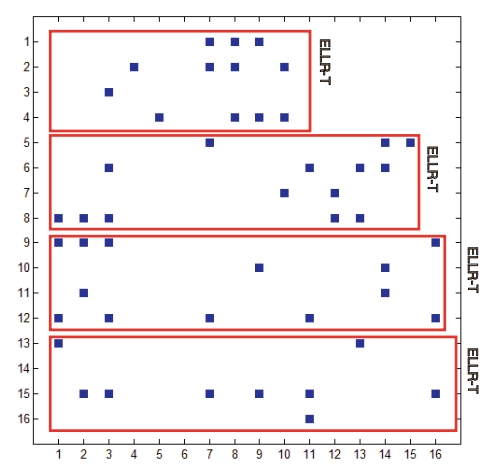

Figure 1: Sliced ELLR format [2]

##**Discretise Poisson function**

We first define the function that generates the sparse matrix A. This function has been taken from the Techniques of High-Performance Computing Lecture notes. 

In [ ]:
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

We also define the relative error function. We will use this function to compare the results for the different formats employed in SpMV. 

In [ ]:
def e_rel(sol, exact):
  """Return the relative error between the exact and obtained solution"""
  N = sol.shape[0]
  e = np.zeros(shape = N)
  for i in range(N):
    e[i] = abs(sol[i] - exact[i])/abs(exact[i])

  return e

##**CPU implementation**

We now define a EllpackMatrix class derived from scipy.sparse.linalg.LinearOperator. Its constructor takes a Scipy sparse matrix in CSR format, converts it to Ellpack-R and provides three routines for matrix-vector product. The first routine performs SpMV in the Ellpack-R format; the second one in the njitted Ellpack-R format; and the third one the in the njitted CSR format. At the end of this section we will evaluate the performance of the three of them. 

In [ ]:
class EllpackMatrix(LinearOperator):
    def __init__(self, csr_mat):
        #get the data from the csr matrix 
        self.data_csr = csr_mat.data
        self.indices_csr = csr_mat.indices
        self.pointer_csr = csr_mat.indptr

        M = len(self.pointer_csr)-1   #total number of rows 
        self.shape = (M, M)   #shape
        self.dtype = None  #type

        #array to store the actual length of each row
        self.rl = np.zeros(shape = M, dtype = np.int64) 
        for i in range(1, len(self.pointer_csr)):
            self.rl[i-1] = int(self.pointer_csr[i] - self.pointer_csr[i-1])
            
        N = max(self.rl)  #total number of columns

        #dense array with column indices
        self.indices_ell = np.zeros((M, N), dtype = np.int64)

        #dense array for non-zero values
        self.data_ell = np.zeros((M, N), dtype = np.float64)
        
        #append the data and indices to dense arrays
        count = 0
        for row in range(M):
            for ele in range(self.rl[row]):
                self.data_ell[row][ele] = int(self.data_csr[count])
                self.indices_ell[row][ele] = self.indices_csr[count]
                count += 1

    def _matvec(self, v):
      """Evaluates the matrix-vector product with a Ellpack R matrix"""

      #array that stores the result values
      result = np.zeros(shape = v.shape, dtype = np.float64)

      for row in range(len(self.data_ell)):
          tmp = 0
          for ele in range(self.rl[row]):
              tmp += int(self.data_ell[row][ele]) * 
              v[int(self.indices_ell[row][ele])]
          result[row] = tmp

      return result
  
    @staticmethod
    @njit(parallel = True)
    def njit_csr_matvec(data, indices, pointer, v):
      """Evaluates the matrix-vector product with a CSR matrix"""

      #array that stores the result values
      result = np.zeros(shape = v.shape[0], dtype = np.float64)   
      
      #perform calculations
      for row_index in prange(v.shape[0]):
          col_start = pointer[row_index]
          col_end = pointer[row_index + 1]
          for col_index in range(col_start, col_end):
              result[row_index] += data[col_index] * v[indices[col_index]]

      return result

    @staticmethod
    @njit(parallel = True)
    def njit_ellpackr_matvec(data, indices, rl, v):
      """Evaluates the matrix-vector product with a Ellpack R matrix"""

      #array that stores the result values
      result = np.zeros(shape = v.shape, dtype = np.float64)  

      #perform calculations
      for row in prange(len(data)):
          tmp = 0
          for ele in range(rl[row]):
              tmp += int(data[row][ele]) * v[int(indices[row][ele])]
          result[row] = tmp

      return result

We will verify our code for a 1000 × 1000 sparse random matrix with the CRS definition and showing for 3 random vectors that the relative distance of the Ellpack-R matvec to the CRS matvec result is in the order of machine precision.

In [ ]:
#Get the sparse matrix A for N = 100
N = 100
A, b = discretise_poisson(N)
my_sparse_mat = EllpackMatrix(A) 

#iterate over three random vectors to calculate the relative error
#between the ellpack r CPU and njitted crs CPU
for i in range(3):
  x = np.random.randn(my_sparse_mat.shape[1])    #create random array

  #Perform SpMV in ellpackr format
  y_ellpackr = my_sparse_mat @ x

  #Perform SpMV in CRS format
  y_csr = my_sparse_mat.njit_csr_matvec(A.data, A.indices, A.indptr, x)

  #Calculate the error between CRS and Ellpack r
  relative_distance = e_rel(y_ellpackr, y_csr)
  print('The relative error for a sparse matrix of size', A.shape,
        'and random vector', i + 1, 'is', np.mean(relative_distance))

The relative error for a sparse matrix of size (10000, 10000) and random vector 1 is 0.0
The relative error for a sparse matrix of size (10000, 10000) and random vector 2 is 0.0
The relative error for a sparse matrix of size (10000, 10000) and random vector 3 is 0.0


- The relative error for a sparse matrix of size (10000, 10000) and random vector 1 is 0.0
- The relative error for a sparse matrix of size (10000, 10000) and random vector 2 is 0.0
- The relative error for a sparse matrix of size (10000, 10000) and random vector 3 is 0.0


From the results above it can be observed that the error is beyond machine precision. Now, we will benchmark our functions for matrices of different dimensions. 

In [ ]:
#array for the dimensions of our matrices
n = np.array([10, 50, 100, 500, 750, 1000, 1250, 1500]) 
#array of the best times that ellpack r takes in the CPU
ellpackr_time_cpu = np.zeros(len(n)) 
#array of the best times that njitted ellpack r takes in the CPU  
njit_ellpackr_time_cpu = np.zeros(len(n)) 
#array of the best times that njitted CRS takes in the CPU
njit_csr_time_cpu = np.zeros(len(n))      

for i in range(len(n)):
  A, b = discretise_poisson(n[i])     #create a matrix
  my_sparse_mat = EllpackMatrix(A)    #create an object for each matrix
  x = np.random.randn(my_sparse_mat.shape[1])   #create a random vector

  #benchmark the ellpack r in the CPU
  timeit_result_ellpack = %timeit  -o my_sparse_mat._matvec(x)
  ellpackr_time_cpu[i] = timeit_result_ellpack.best

  #benchmark the njitted CRS in the CPU
  timeit_result_csr = %timeit  -o my_sparse_mat.njit_csr_matvec(A.data, 
                                                        A.indices, A.indptr, x)
  njit_csr_time_cpu[i] = timeit_result_csr.best

  #benchmark the njitted ellpack r in the CPU
  timeit_result_csr = %timeit  -o my_sparse_mat.njit_ellpackr_matvec(my_sparse_mat.data_ell, 
                                my_sparse_mat.indices_ell, my_sparse_mat.rl, x)
  njit_ellpackr_time_cpu[i] = timeit_result_csr.best

1000 loops, best of 5: 665 µs per loop
The slowest run took 157.48 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 6.42 µs per loop
The slowest run took 84251.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 8.53 µs per loop
10 loops, best of 5: 20.9 ms per loop
The slowest run took 44.72 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 21.5 µs per loop
The slowest run took 5.98 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 21.5 µs per loop
10 loops, best of 5: 89.1 ms per loop
The slowest run took 15.50 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 67.4 µs per loop
10000 loops, best of 5: 59.1 µs per loop
1 loop, best of 5: 2.29 s per loop
1000 loops

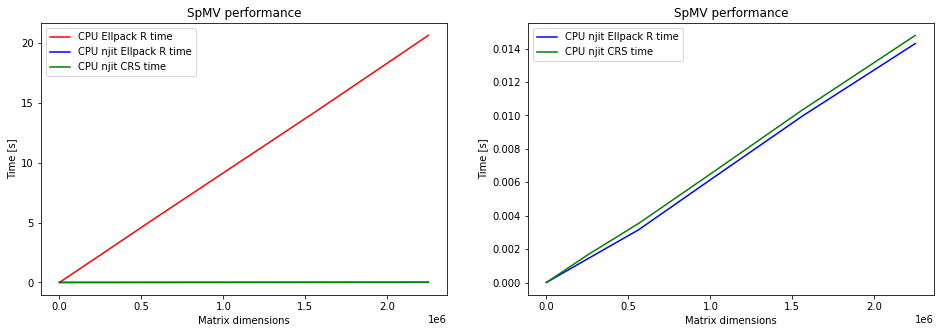

In [ ]:
#Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,5))
ax1.plot(n**2, ellpackr_time_cpu, 'r', label = 'CPU Ellpack R time')
ax1.plot(n**2, njit_ellpackr_time_cpu, 'b', label = 'CPU njit Ellpack R time')
ax1.plot(n**2, njit_csr_time_cpu, 'g', label = 'CPU njit CRS time')

ax2.plot(n**2, njit_ellpackr_time_cpu, 'b', label = 'CPU njit Ellpack R time')
ax2.plot(n**2, njit_csr_time_cpu, 'g', label = 'CPU njit CRS time')

#Set the labels, legends and title
ax1.set_xlabel('Matrix dimensions')
ax1.set_ylabel('Time [s]')
ax1.set_title('SpMV performance')
ax1.legend()

ax2.set_xlabel('Matrix dimensions')
ax2.set_ylabel('Time [s]')
ax2.set_title('SpMV performance')
ax2.legend()

#Show results
plt.show()

From the first graph, it can be observed that the Ellpack R performs the worst compared to the njitted versions of CSR and ELLR. However, the second graph shows that the njitted Ellpack R and CSR performs similarly, with the njitted CRS format performing slightly better for all dimensions.

##**GPU implementation**

We will briefly describe some of the key aspects of GPU programming. GPU's have many processors (multiprocessor) that execute in parallel a kernel called from the CPU on different data. Threads are grouped into blocks which share memory from the multiprocessor (global and shared memory), and blocks are further grouped into grids [2]. To obtain the best performance, it is important to take into account the following aspects: 
- guarantee coalesced access to global memory
- use shared memory as much as possible
- replace global memory accesses with shared memory accesses (if possible)

Now, we will define our kernel. In the CPU version for the Ellpack R format, the maximum number of columns is the maximum number of non-zero elements for the whole matrix. However, in our GPU implementation we change that so that each row has the same number of elements as a thread block. Then we flatten it, so that we input a 1D array to the kernel to perform the multiplication. 

In [ ]:
#Define the kernel
TPB = 64   #threadsperblock
@cuda.jit()
def kernel_matvec(data, indices, rl, v, result):

    #Define array in the shared memory
    local_data = cuda.shared.array(shape = TPB, dtype = float64)
    local_indices = cuda.shared.array(shape = TPB, dtype = int64)

    x = cuda.grid(1)         #global position
    tx = cuda.threadIdx.x    #thread id
    bidx = cuda.blockIdx.x   #block position
    bdim = cuda.blockDim.x   #block width 
    index = cuda.blockIdx.x * cuda.blockDim.x

    #global position is within the dimension of our data
    if x < data.shape[0]:
      tmp = 0.
      
      if index + rl[bidx] > tx:
        #store data in shared memory
        local_data[tx] = data[index + tx]
        local_indices[tx] = indices[index + tx]

        cuda.syncthreads()

      #perform calculations
      for tx in range(rl[bidx]):
        tmp += local_data[tx] * v[local_indices[tx]]

      cuda.syncthreads()

    #append result
    result[bidx] = tmp

In [ ]:
#Define the class
class EllpackMatrix(LinearOperator):
    def __init__(self, csr_mat):
        #get the data from the csr matrix 
        data_csr = csr_mat.data
        indices_csr = csr_mat.indices
        pointer_csr = csr_mat.indptr

        M = len(pointer_csr)-1   #total number of rows 

        self.TPB = 64   #threads per block
        self.blockspergrid = M   #blocks per grid

        self.shape = (M, M)   #shape
        self.dtype = None  #type
        #array to store the actual length of each row

        rl = np.zeros(shape = M, dtype = np.int64) 

        for i in range(1, len(pointer_csr)):
            rl[i-1] = int(pointer_csr[i] - pointer_csr[i-1])

        #padding the rows with zeros so that each calculation 
        #is acted on by a block of threads
        indices_ell = np.zeros((M, self.TPB), dtype = np.int64)   
        data_ell = np.zeros((M, self.TPB), dtype = np.float64)  
        
        #append results
        count = 0
        for row in range(M):
            for ele in range(rl[row]):
                data_ell[row][ele] = int(data_csr[count])
                indices_ell[row][ele] = indices_csr[count]
                count += 1

        #send 1D data to device
        self.dev_data = cuda.to_device(np.ravel(data_ell))
        self.dev_indices = cuda.to_device(np.ravel(indices_ell))
        self.dev_rl = cuda.to_device(rl)
        result = np.zeros(M)
        self.dev_result = cuda.to_device(result)

    def _matvec(self, v):
      """Evaluates the matrix-vector product with a Ellpack R matrix"""
      #send array to device
      dev_v = cuda.to_device((v))
      #call the kernel
      kernel_matvec[self.blockspergrid, self.TPB](self.dev_data, 
                        self.dev_indices, self.dev_rl, dev_v, self.dev_result)

    @staticmethod
    @njit(parallel = True)
    def njit_csr_matvec(data, indices, pointer, v):
      """Evaluates the matrix-vector product with a CSR matrix"""

      result = np.zeros(shape = v.shape[0], dtype = np.float64) 
      
      #perform calculations
      for row_index in prange(v.shape[0]):
          col_start = pointer[row_index]
          col_end = pointer[row_index + 1]
          for col_index in range(col_start, col_end):
              result[row_index] += data[col_index] * v[indices[col_index]]

      return result

We will verify our code for a 1000 × 1000 sparse random matrix with the CSR definition and showing for 3 random vectors that the relative distance of the Ellpack-R matvec to the CSR matvec result is in the order of machine precision.

In [ ]:
#Get the sparse matrix A for N = 100
N = 100
A, b = discretise_poisson(N)
my_sparse_mat = EllpackMatrix(A)

#iterate over three random vectors to calculate the relative error
#between the ellpack r GPU and njitted crs CPU
for i in range(3):
  x = np.random.randn(my_sparse_mat.shape[1])

  #Perform SpMV in ellpackr format in the GPU
  my_sparse_mat @ x
  ary = np.empty(shape = my_sparse_mat.shape[0],
                 dtype = my_sparse_mat.dev_result.dtype)
  my_sparse_mat.dev_result.copy_to_host(ary)  #call result to the device
  dev_result = ary

  #Perform SpMV in CRS format in the CPU
  y_csr = my_sparse_mat.njit_csr_matvec(A.data, A.indices, A.indptr, x)

  #Calculate the relative error
  relative_distance = e_rel(dev_result, y_csr)

  print('The relative error for a sparse matrix of size', A.shape,
        'and random vector',i + 1, 'is', np.mean(relative_distance))

The relative error for a sparse matrix of size (10000, 10000) and random vector 1 is 1.672604893197956e-16
The relative error for a sparse matrix of size (10000, 10000) and random vector 2 is 2.699765051156537e-16
The relative error for a sparse matrix of size (10000, 10000) and random vector 3 is 1.686602311585923e-16


- The relative error for a sparse matrix of size (10000, 10000) and random vector 1 is 1.672604893197956e-16
- The relative error for a sparse matrix of size (10000, 10000) and random vector 2 is 2.699765051156537e-16
- The relative error for a sparse matrix of size (10000, 10000) and random vector 3 is 1.686602311585923e-16


From the results above it can be observed that the error is deu to machine precision. Now, we will benchmark our functions for matrices of different dimensions. 

In [ ]:
#array for the dimensions of our matrices
n = np.array([10, 50, 100, 500, 750, 1000, 1250, 1500]) 
#array of the best times that numpy function takes
ellpackr_time_gpu = np.zeros(len(n))      

for i in range(len(n)):
  A, b = discretise_poisson(n[i])   #generate the matrices
  my_sparse_mat = EllpackMatrix(A)  #create an object
  x = np.random.randn(my_sparse_mat.shape[1])   #generate random array

  #benchmark SpMV in the ellpack r format in the GPU
  timeit_result_ellpack = %timeit  -o my_sparse_mat @ x
  ellpackr_time_gpu[i] = timeit_result_ellpack.best


1000 loops, best of 5: 852 µs per loop
1000 loops, best of 5: 848 µs per loop
1000 loops, best of 5: 848 µs per loop
1000 loops, best of 5: 1.79 ms per loop
100 loops, best of 5: 3.39 ms per loop
100 loops, best of 5: 5.54 ms per loop
100 loops, best of 5: 8.28 ms per loop
100 loops, best of 5: 11.8 ms per loop


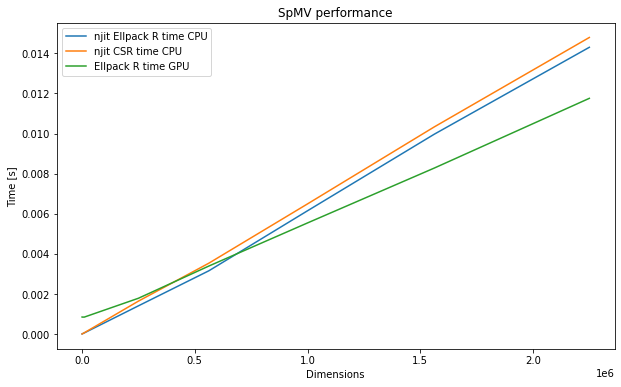

In [ ]:
#Plot the best times against the number of dimensions
plt.figure(figsize =(10,6))
plt.plot(n**2, njit_ellpackr_time_cpu, label = 'njit Ellpack R time CPU')
plt.plot(n**2, njit_csr_time_cpu, label = 'njit CSR time CPU')
plt.plot(n**2, ellpackr_time_gpu, label = 'Ellpack R time GPU')

#Set the legend, labels and title
plt.title("SpMV performance")
plt.xlabel("Dimensions")
plt.ylabel("Time [s]")
plt.legend()

#Plot results
plt.show()

From the graph above, it can be observed that SpMV with Ellpack R in the GPU performs better than the njitted version of CRS and Ellpack R for higher dimensions. Particularly, our GPU implementation starts performing better for dimensions above 750000. One of the reasons why Ellpack R on the GPU does not perform better for lower dimensions could be due to padding the rows with zeros so that each calculation is acted on by a block of threads. Although this is a ncessary step to ensure coalesced global memory access, it is also decreasing performance due to storing unnecesary elements. 

## **Matrix testing**

In the following section, we will evaluate our code for three matrices obtained from the Matrix Market. The information for the matrices are presented in the following table:

Matrix | Name | Description | Size | Type | Bytes in CRS | Bytes in Ellpack R
--- | --- | --- | --- | --- | --- | ---
1 | JPWH 991 | Circuit physics modeling | 991 x 991, 6027 entries | real unsymmetric | 21387 | 24444
2 | CONF5.0-00L4X4-1000 | Quantum Chromodynamics | 3072 x 3072, 119808 entries | matrix coordinate complex general | 972988 | -
3 | GRE 115 | Simulation of computer systems | 115 x 115, 421 entries | real unsymmetric | 1916 | 15132



From the table above, it can be observed that when we store our matrices in Ellpack R format, it requires more space than in CSR. This is due to the zero-padding that we performed previous to the SpMV operation. Given the dimensions of the matrices, we expect that the CSR in the CPU performs better than the Ellpack R in the GPU. 

The space that the Ellpack R requires has been calculated using the following formula:

$ELLR = (2 \times (N_{max} \times N')\times 8bytes +(N_{max}\times N' + N)\times 4 bytes)$

In [ ]:
#load the matrices and store them in CRS format
matrix1 = scipy.io.mmread('/content/matrix1.mtx')
matrix2 = scipy.io.mmread('/content/matrix1.mtx')
matrix3 = scipy.io.mmread('/content/matrix1.mtx')

matrix1 = csr_matrix(matrix1)
matrix2 = csr_matrix(matrix2)
matrix3 = csr_matrix(matrix3)

matrices = [matrix1, matrix2, matrix3]

In [ ]:
#iterate over all the matrices to calculate the relative error
#between the ellpack r GPU and njitted crs CPU

for i in range(len(matrices)):
  my_sparse_mat = EllpackMatrix(matrices[i])  #create an object for each matrix
  x = np.random.randn(my_sparse_mat.shape[1])   #create random array

  my_sparse_mat @ x  #SpMV with ellpack r GPU

  #call the result from the kernel to the host
  ary = np.empty(shape = my_sparse_mat.shape[0], 
                 dtype = my_sparse_mat.dev_result.dtype)
  my_sparse_mat.dev_result.copy_to_host(ary)
  dev_result = ary  

  #SpMV with njitted crs CPU
  y_csr = my_sparse_mat.njit_csr_matvec(matrices[i].data, matrices[i].indices, 
                                        matrices[i].indptr, x)

  #calculate the error
  relative_distance = e_rel(dev_result, y_csr)

  print('The mean relative error for random vector',i, 'is', 
        np.mean(relative_distance),)

The mean relative error for random vector 0 is 3.190203192378855e-17 .
The mean relative error for random vector 1 is 6.083056153586919e-16 .
The mean relative error for random vector 2 is 9.141601210345653e-17 .


The error is in the order of machine precision. Now we will evaluate how fast our Ellpack R GPU is compared to the njitted CRS SpMV. 

In [ ]:
#array storing the best times for gpu ellpack r
ellpackr_time_gpu = np.zeros(len(matrices))
#array storing the best times for cpu njitted crs
csr_njitted_time_cpu = np.zeros(len(matrices))  

for i in range(len(matrices)):

  my_sparse_mat = EllpackMatrix(matrices[i])   #create an object for each matrix
  x = np.random.randn(my_sparse_mat.shape[1])  #create random array

  #benchmark the ellpack r GPU
  timeit_result_ellpack_gpu = %timeit  -o my_sparse_mat @ x
  ellpackr_time_gpu[i] = timeit_result_ellpack_gpu.best
 
  #benchmark the njitted crs CPU
  timeit_result_ellpack_cpu = %timeit  -o my_sparse_mat.njit_csr_matvec(matrices[i].data, 
                                    matrices[i].indices, matrices[i].indptr, x)
  csr_njitted_time_cpu[i] = timeit_result_ellpack_cpu.best

1000 loops, best of 5: 862 µs per loop
The slowest run took 7.06 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 14.8 µs per loop
1000 loops, best of 5: 841 µs per loop
The slowest run took 7.06 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 14.6 µs per loop
1000 loops, best of 5: 847 µs per loop
The slowest run took 72.67 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 14.4 µs per loop


In [ ]:
ratio =  ellpackr_time_gpu / csr_njitted_time_cpu

for i in range(len(matrices)):
  print('SpMV using njitted CRS format in the CPU is', ratio[i], 
        'faster than Ellpack R in GPU.')

SpMV using njitted CRS format in the CPU is 58.193408141934924 faster than Ellpack R in GPU.
SpMV using njitted CRS format in the CPU is 57.78133809025549 faster than Ellpack R in GPU.
SpMV using njitted CRS format in the CPU is 58.68481540314007 faster than Ellpack R in GPU.


- SpMV using njitted CRS format in the CPU is 58.193408141934924 faster than Ellpack R in GPU.
- SpMV using njitted CRS format in the CPU is 57.78133809025549 faster than Ellpack R in GPU.
- SpMV using njitted CRS format in the CPU is 58.68481540314007 faster than Ellpack R in GPU.

Effectively, the njitted CSR format performs better, approximately 60 times faster than the Ellpack R in the GPU for all our matrices. This is again due to the low dimensionality of our matrices. However, one way to overcome the zero-padding problem is by using Sliced ELLR-T. By cutting the matrix into slices, this storing format significantly reduces the amount of memory required for storage (down to about one third) and it is nearly as effective as the CSR format for lower dimensions.

## **Conclusions**

- In the CSR format, data access locality is not maintained and parallelism of loops is not totally exploited. Ellpack R overcome these challenges, but does not fully overcome the CSR format, as the padding with zero elements requires more space, and hence more time. 
- For dimensions lower to 750.000, the njitted CSR format in the CPU performed the best. For dimensions above 750.000, the Ellpack R in the GPU performed the best. 
- Padding the rows with zeros so that each calculation is acted on by a block of threads in the Ellpack-R format ensures coalesced global memory access. However, it decreases performance due to storing unnecesary elements. 
- This issue could be overcome by using Sliced ELLR-T, which significantly reduces the amount of memory required for storage. 

## **References**

[1] Dziekonski, Adam, Adam Lamecki and Michał Mrozowski. “A Memory Efficient and Fast Sparse Matrix Vector Product on a GPU.” Progress in Electromagnetics Research-pier 116 (2011): 49-63.

[2] F. Vázquez, G. Ortega, J. J. Fernández and E. M. Garzón, "Improving the Performance of the Sparse Matrix Vector Product with GPUs," 2010 10th IEEE International Conference on Computer and Information Technology, 2010, pp. 1146-1151, doi: 10.1109/CIT.2010.208.
